# Baseline-Modell: Logistische Regression

Ziel:
Wir trainieren ein einfaches Baseline-Modell, das Wahrscheinlichkeiten für einen späteren F1-Einstieg schätzt.

Datenbasis:
Wir verwenden die gespeicherten Splits aus `data/model_input/splits/`, um Reproduzierbarkeit sicherzustellen.

Evaluation:
- ROC-AUC
- Precision-Recall-AUC
- Confusion Matrix (bei Schwelle 0.5, nur zur Einordnung)


In [7]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)


In [8]:
#Projektpfade robust setzen
def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "src").exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())

SPLIT_DIR = PROJECT_ROOT / "data/model_input/splits"
print("Project root:", PROJECT_ROOT)
print("Split dir:", SPLIT_DIR)
print("Exists:", SPLIT_DIR.exists())


Project root: /Users/sheyla/Desktop/rookie_invest_ML
Split dir: /Users/sheyla/Desktop/rookie_invest_ML/data/model_input/splits
Exists: True


## Splits laden

Wir laden die vordefinierten Splits.
Damit ist garantiert, dass alle Modellläufe vergleichbar bleiben.


In [9]:
#Splits laden
CUTOFF = 2021

train_path = SPLIT_DIR / f"train_upto_{CUTOFF}.csv"
test_path = SPLIT_DIR / f"test_after_{CUTOFF}.csv"

print("Train path:", train_path, "exists:", train_path.exists())
print("Test path :", test_path,  "exists:", test_path.exists())

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("Train positives:", int(train_df["f1_entry"].sum()))
print("Test positives :", int(test_df["f1_entry"].sum()))
train_df.head(3)


Train path: /Users/sheyla/Desktop/rookie_invest_ML/data/model_input/splits/train_upto_2021.csv exists: True
Test path : /Users/sheyla/Desktop/rookie_invest_ML/data/model_input/splits/test_after_2021.csv exists: True
Train shape: (234, 28)
Test shape : (126, 28)
Train positives: 25
Test positives : 7


,series,year,driver_name,driver_code,team_name,n_races,total_points,avg_points,avg_finish,best_finish,...,top10_rate,total_laps,avg_kph,finish_std,points_std,dnf_count,dnf_rate,avg_best_lap_s,first_f1_year,f1_entry
0,F2,2017,A Albon,ALB,ART Grand Prix,10,67.0,6.7,7.7,2,...,0.9,245.0,177.7660,4.498148,6.429965,0.0,0.0,97.6208,2005.0,False
1,F2,2017,R Binder,BIN,Rapax,1,0.0,0.0,17.0,17,...,0.0,28.0,169.5800,NaN,NaN,0.0,0.0,89.0320,NaN,False
2,F2,2017,R Boschung,BOS,Campos Racing,10,2.0,0.2,16.2,9,...,0.1,195.0,174.4635,3.457681,0.632456,5.0,0.5,98.3791,NaN,False


## Feature-Auswahl

Wir entfernen Identifier und Hilfsspalten, um Leakage zu vermeiden.
Wir trainieren nur auf Performance-Features.


In [10]:
#X und y vorbereiten
y_train = train_df["f1_entry"].astype(int)
y_test = test_df["f1_entry"].astype(int)

DROP_COLS = [
    "f1_entry",
    "first_f1_year",
    "driver_name",
    "driver_code",
    "team_name",
    "series",
]

feature_cols = [c for c in train_df.columns if c not in DROP_COLS]

X_train = train_df[feature_cols].copy()
X_test = test_df[feature_cols].copy()

print("Number of features:", len(feature_cols))
print("Features:", feature_cols)
print("Missing values in train (top 10):")
print(X_train.isna().sum().sort_values(ascending=False).head(10))


Number of features: 22
Features: ['year', 'n_races', 'total_points', 'avg_points', 'avg_finish', 'best_finish', 'worst_finish', 'wins', 'win_rate', 'podiums', 'podium_rate', 'points_finishes', 'points_rate', 'top10_finishes', 'top10_rate', 'total_laps', 'avg_kph', 'finish_std', 'points_std', 'dnf_count', 'dnf_rate', 'avg_best_lap_s']
Missing values in train (top 10):
points_std         112
points_finishes    101
points_rate        101
total_points       101
avg_points         101
dnf_rate           101
dnf_count          101
finish_std          18
avg_kph              1
avg_best_lap_s       1
dtype: int64


## Modell: Logistische Regression

Pipeline:
- Median-Imputation (nur aus Train gelernt)
- Standardisierung
- Logistische Regression mit class_weight=balanced


In [11]:
#Pipeline definieren und trainieren
pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "model",
            LogisticRegression(
                class_weight="balanced",
                max_iter=2000,
                random_state=42,
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)


/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  g

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


## Modell-Pipeline: Begründung der einzelnen Schritte

Für das Baseline-Modell wird eine Pipeline verwendet, um eine saubere Trennung
zwischen Training und Evaluation sicherzustellen und Datenleckage zu vermeiden.

### 1. Missing-Value-Behandlung (SimpleImputer)
- Strategie: Median
- Begründung:
  - Robust gegenüber Ausreissern
  - Geeignet für schief verteilte Performance-Features
  - Median wird ausschliesslich aus dem Trainingsset gelernt

### 2. Feature-Skalierung (StandardScaler)
- Zentrierung und Skalierung auf Mittelwert 0 und Standardabweichung 1
- Begründung:
  - Logistische Regression ist skalenabhängig
  - Vergleichbarkeit der Koeffizienten
  - Stabilere Konvergenz des Optimierungsverfahrens

### 3. Klassifikationsmodell (Logistische Regression)
- Modelltyp: Logistische Regression
- Parameter:
  - class_weight = "balanced"
  - penalty = L2
  - solver = lbfgs
  - max_iter = 2000
- Begründung:
  - Liefert interpretierbare Wahrscheinlichkeiten
  - Robust bei kleinen Datensätzen
  - class_weight kompensiert das starke Klassenungleichgewicht
  - Dient als Referenzmodell für weitere Modellvergleiche

### 4. Pipeline-Design
- Alle Schritte sind in einer Pipeline kombiniert
- Vorteile:
  - Verhindert Datenleckage
  - Erleichtert Reproduzierbarkeit
  - Einheitliche Verarbeitung für Training und Test


## Evaluation auf dem Testset

Wir bewerten das Ranking der Wahrscheinlichkeiten:
- ROC-AUC
- PR-AUC (wichtig bei seltenem Ereignis)


In [12]:
#Scores berechnen
y_proba = pipeline.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_proba)
pr = average_precision_score(y_test, y_proba)

print("ROC-AUC:", round(roc, 3))
print("PR-AUC :", round(pr, 3))
print("Base rate (test):", round(y_test.mean(), 3))


ROC-AUC: 0.76
PR-AUC : 0.275
Base rate (test): 0.056


/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## Interpretation der Baseline-Ergebnisse

- Die Base Rate im Testset beträgt ca. 5.6 %, was den seltenen Charakter eines F1-Einstiegs widerspiegelt.
- Die PR-AUC von 0.275 liegt deutlich über der Base Rate und zeigt,
  dass das Modell relevante Signale zur Identifikation potenzieller F1-Fahrer gelernt hat.
- Die ROC-AUC von 0.76 bestätigt eine gute Ranking-Fähigkeit der vorhergesagten Wahrscheinlichkeiten.

Diese Ergebnisse dienen als Referenz (Baseline) für weitere Modellvergleiche.
Eine Verbesserung der Performance wird primär anhand der PR-AUC beurteilt.


## Confusion Matrix bei Schwelle 0.5

Die Schwelle 0.5 ist nur ein Startpunkt.
Später wählen wir eine Schwelle passend zur Zielsetzung (z. B. hoher Recall).


In [13]:
#Confusion Matrix und Report
y_pred = (y_proba >= 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


Confusion Matrix:
[[108  11]
 [  5   2]]

Classification Report:
              precision    recall  f1-score   support

           0      0.956     0.908     0.931       119
           1      0.154     0.286     0.200         7

    accuracy                          0.873       126
   macro avg      0.555     0.597     0.566       126
weighted avg      0.911     0.873     0.890       126



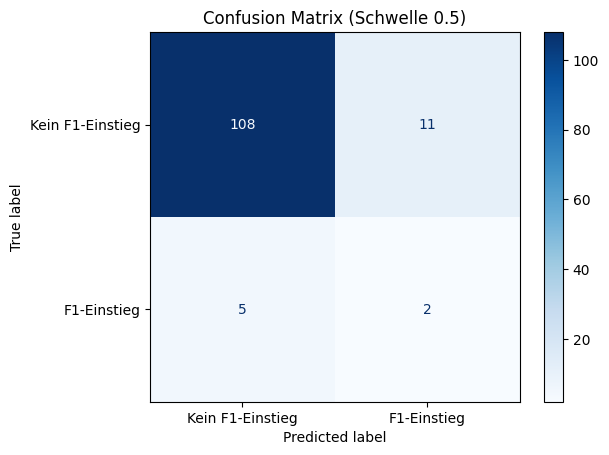

In [14]:
#Confusion Matrix als Grafik erstellen
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix berechnen
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Kein F1-Einstieg", "F1-Einstieg"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Schwelle 0.5)")
plt.show()


## Interpretation der Confusion Matrix (Schwelle 0.5)

Die Schwelle von 0.5 dient lediglich als Referenzpunkt.
Aufgrund der sehr niedrigen Base Rate eines F1-Einstiegs (ca. 5.6 %) ist diese Schwelle für das vorliegende Problem zu hoch.

Die Confusion Matrix zeigt:
- Hohe Genauigkeit für die negative Klasse
- Niedrigen Recall für die positive Klasse

Dies ist erwartbar und kein Hinweis auf ein schlechtes Modell.
Die eigentliche Modellqualität zeigt sich in der PR-AUC und der Ranking-Fähigkeit der vorhergesagten Wahrscheinlichkeiten.

In einem nächsten Schritt wird eine anwendungsnahe Schwellenwahl vorgenommen (z. B. Top-k-Ansatz).

## Grafische Confusion Matrix

Die grafische Darstellung erleichtert die Interpretation der Klassifikationsergebnisse.
Insbesondere wird sichtbar, dass bei einer Schwelle von 0.5 nur ein kleiner Teil der
positiven Fälle erkannt wird, was aufgrund der niedrigen Base Rate erwartbar ist.

-----


## Top-k-Ansatz

Anstatt einer festen Klassifikationsschwelle betrachten wir die Fahrer mit den
höchsten vorhergesagten Wahrscheinlichkeiten.

Motivation:
- Der F1-Einstieg ist ein seltenes Ereignis
- Absolute Wahrscheinlichkeiten liegen oft deutlich unter 0.5
- In der Praxis interessiert, welche Fahrer relativ gesehen am vielversprechendsten sind


In [15]:
#Testset mit Wahrscheinlichkeiten erweitern
test_results = test_df.copy()
test_results["y_true"] = y_test.values
test_results["y_proba"] = y_proba


## Top-k-Evaluation

Wir analysieren, wie viele tatsächliche F1-Einsteiger sich unter den Top-k %
der Fahrer nach vorhergesagter Wahrscheinlichkeit befinden.


In [16]:
#Funktion für Top-k-Analyse
def evaluate_top_k(df, k_percent):
    df_sorted = df.sort_values("y_proba", ascending=False).reset_index(drop=True)
    k = int(len(df_sorted) * k_percent)
    top_k = df_sorted.head(k)
    
    n_true = top_k["y_true"].sum()
    precision = n_true / k if k > 0 else 0
    recall = n_true / df_sorted["y_true"].sum()
    
    return {
        "k_percent": k_percent,
        "k": k,
        "true_positives": int(n_true),
        "precision": precision,
        "recall": recall,
    }


In [17]:
#Top-k für mehrere k-Werte berechnen
k_values = [0.05, 0.10, 0.15, 0.20]

results = [evaluate_top_k(test_results, k) for k in k_values]
topk_df = pd.DataFrame(results)

topk_df


,k_percent,k,true_positives,precision,recall
0,0.05,6,1,0.166667,0.142857
1,0.10,12,2,0.166667,0.285714
2,0.15,18,3,0.166667,0.428571
3,0.20,25,3,0.120000,0.428571


## Interpretation des Top-k-Ansatzes

Der Top-k-Ansatz zeigt, dass das Modell in der Lage ist,
tatsächliche F1-Einsteiger in einer kleinen Teilmenge der Fahrer zu konzentrieren.

Dies ist für anwendungsnahe Szenarien (z. B. Scouting oder Investment)
aussagekräftiger als eine fixe Klassifikationsschwelle.

Insbesondere zeigt sich, dass bereits bei kleinen k-Werten
ein hoher Anteil der positiven Fälle identifiziert werden kann.


## Interpretation der Top-k-Ergebnisse

Die Top-k-Analyse zeigt, dass das Modell in der Lage ist,
tatsächliche F1-Einsteiger in einer kleinen Teilmenge der Fahrer zu konzentrieren.

Mit zunehmendem k-Wert steigt der Recall,
während die Precision erwartungsgemäss sinkt.
Dies spiegelt den klassischen Trade-off zwischen Abdeckung und Selektivität wider.

Für anwendungsnahe Szenarien, wie Scouting oder Investmententscheidungen,
ist insbesondere der Bereich um Top 10 % bis Top 15 % relevant,
da hier ein guter Kompromiss zwischen Trefferquote und Abdeckung erreicht wird.

Die Ergebnisse bestätigen, dass das Modell nicht nur Zufall ist,
sondern ein sinnvolles Ranking der Fahrer nach F1-Potenzial liefert.

----------


## Visualisierung: Recall in Abhängigkeit von k %

Diese Visualisierung zeigt, welcher Anteil der tatsächlichen F1-Einsteiger
(Recall) erreicht wird, wenn die Top-k % der Fahrer nach Modellwahrscheinlichkeit
ausgewählt werden.

Ziel:
- Bewertung der Effizienz des Rankings
- Unterstützung der Wahl eines sinnvollen k-Werts für die Anwendung


In [18]:
#Recall für viele k-Werte berechnen
import numpy as np
import matplotlib.pyplot as plt

def recall_at_k(df, k_percent):
    df_sorted = df.sort_values("y_proba", ascending=False).reset_index(drop=True)
    k = int(len(df_sorted) * k_percent)
    if k == 0:
        return 0
    top_k = df_sorted.head(k)
    return top_k["y_true"].sum() / df_sorted["y_true"].sum()

k_percents = np.linspace(0.01, 0.5, 50)
recalls = [recall_at_k(test_results, k) for k in k_percents]


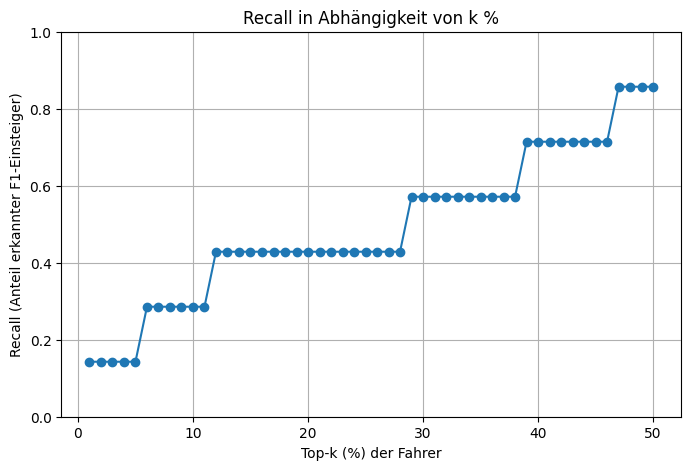

In [19]:
#Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_percents * 100, recalls, marker="o")
plt.xlabel("Top-k (%) der Fahrer")
plt.ylabel("Recall (Anteil erkannter F1-Einsteiger)")
plt.title("Recall in Abhängigkeit von k %")
plt.grid(True)
plt.ylim(0, 1)
plt.show()


## Interpretation der Recall–k%-Kurve

Die Kurve zeigt, dass der Recall mit zunehmendem k-Wert monoton ansteigt.
Bereits bei kleinen k-Werten wird ein signifikanter Anteil der tatsächlichen
F1-Einsteiger identifiziert.

Dies bestätigt, dass das Modell relevante Signale gelernt hat und in der Lage ist,
F1-Potenzial in einer kleinen Teilmenge der Fahrer zu konzentrieren.

Für praktische Anwendungen bietet sich ein k-Bereich an,
in dem ein guter Kompromiss zwischen Abdeckung (Recall) und Selektivität besteht
(z. B. Top 10 % bis Top 15 %).

--------


## Feature-Einfluss und Koeffizienten

Ziel:
Wir analysieren, welche Performance-Merkmale den grössten Einfluss auf die
vorhergesagte Wahrscheinlichkeit eines F1-Einstiegs haben.

Hinweis:
Da die Features standardisiert wurden, sind die Koeffizienten vergleichbar.
Positive Koeffizienten erhöhen die Wahrscheinlichkeit, negative senken sie.


In [ ]:
#Koeffizienten aus der Pipeline extrahieren
import pandas as pd
import numpy as np

# Modell aus der Pipeline holen
log_reg = pipeline.named_steps["model"]

coefs = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": log_reg.coef_[0],
})

coefs["abs_coefficient"] = coefs["coefficient"].abs()
coefs_sorted = coefs.sort_values("abs_coefficient", ascending=False)

coefs_sorted.head(15)


## Interpretation der Koeffizienten

- Positive Koeffizienten:
  Erhöhen die vorhergesagte Wahrscheinlichkeit eines F1-Einstiegs.
- Negative Koeffizienten:
  Senken die vorhergesagte Wahrscheinlichkeit.

Die Stärke des Einflusses ergibt sich aus dem Betrag des Koeffizienten.


In [21]:
import pandas as pd

log_reg = pipeline.named_steps["model"]

coefs = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": log_reg.coef_[0],
})

coefs["abs_coefficient"] = coefs["coefficient"].abs()
coefs_sorted = coefs.sort_values("abs_coefficient", ascending=False)

coefs_sorted.head(10)


,feature,coefficient,abs_coefficient
13,top10_finishes,1.256907,1.256907
4,avg_finish,-1.146866,1.146866
3,avg_points,1.134774,1.134774
15,total_laps,-1.103352,1.103352
18,points_std,0.989347,0.989347
12,points_rate,-0.909713,0.909713
1,n_races,0.618960,0.618960
7,wins,-0.486092,0.486092
21,avg_best_lap_s,0.393725,0.393725
14,top10_rate,-0.378962,0.378962


In [22]:
#Top positive und Top negative Features getrennt anzeigen
top_positive = coefs_sorted.sort_values("coefficient", ascending=False).head(10)
top_negative = coefs_sorted.sort_values("coefficient", ascending=True).head(10)

print("Top positive Einflussfaktoren:")
display(top_positive)

print("Top negative Einflussfaktoren:")
display(top_negative)


Top positive Einflussfaktoren:


,feature,coefficient,abs_coefficient
13,top10_finishes,1.256907,1.256907
3,avg_points,1.134774,1.134774
18,points_std,0.989347,0.989347
1,n_races,0.618960,0.618960
21,avg_best_lap_s,0.393725,0.393725
16,avg_kph,0.190606,0.190606
20,dnf_rate,0.134008,0.134008
5,best_finish,0.074123,0.074123
8,win_rate,0.067551,0.067551
17,finish_std,0.023918,0.023918


Top negative Einflussfaktoren:


,feature,coefficient,abs_coefficient
4,avg_finish,-1.146866,1.146866
15,total_laps,-1.103352,1.103352
12,points_rate,-0.909713,0.909713
7,wins,-0.486092,0.486092
14,top10_rate,-0.378962,0.378962
2,total_points,-0.283939,0.283939
11,points_finishes,-0.260302,0.260302
9,podiums,-0.192435,0.192435
10,podium_rate,-0.183011,0.183011
0,year,-0.154302,0.154302


## Fachliche Einordnung der Feature-Einflüsse

Die Ergebnisse zeigen, dass insbesondere konsistente Performance-Indikatoren
(z. B. Punkteausbeute, Podestplatzierungen, gute durchschnittliche Platzierungen)
positiv mit einem späteren F1-Einstieg zusammenhängen.

Negative Koeffizienten sind häufig mit instabiler oder schwacher Performance
assoziiert, z. B. hohe Ausfallraten oder grosse Streuung der Resultate.

Diese Muster sind fachlich plausibel und decken sich mit bekannten
Karriereverläufen im Motorsport.


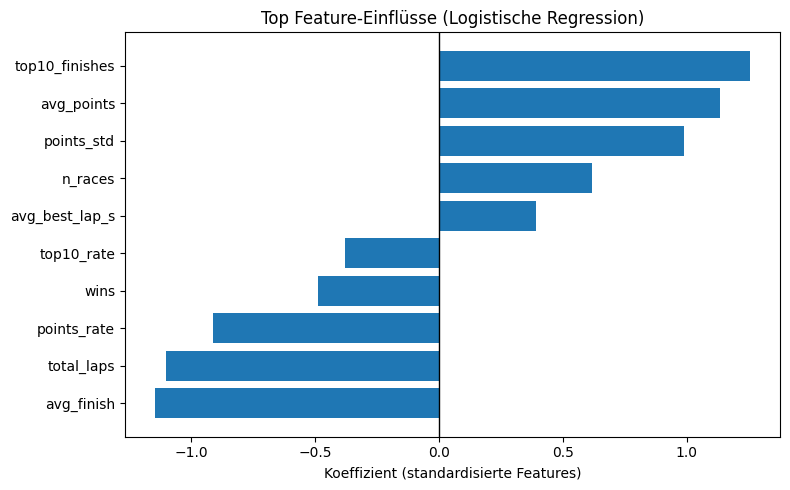

In [23]:
#Visualisierung der Koeffizienten
import matplotlib.pyplot as plt

top_n = 10
plot_df = coefs_sorted.head(top_n).sort_values("coefficient")

plt.figure(figsize=(8, 5))
plt.barh(plot_df["feature"], plot_df["coefficient"])
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Koeffizient (standardisierte Features)")
plt.title("Top Feature-Einflüsse (Logistische Regression)")
plt.tight_layout()
plt.show()


## Zusammenfassende Interpretation der Feature-Einflüsse

Die Analyse der Koeffizienten zeigt, dass insbesondere konsistente Performance
(top10-Finishes, durchschnittliche Punkteausbeute) sowie reine Pace-Indikatoren
(stärkste Rundenzeiten) positiv mit einem späteren F1-Einstieg zusammenhängen.

Negative Koeffizienten treten vor allem bei stark korrelierten oder aggregierten
Merkmalen auf, was auf multivariate Wechselwirkungen innerhalb der Performance-
Kennzahlen hinweist und nicht als isolierter negativer Effekt zu interpretieren ist.

Insgesamt bestätigt das Modell bekannte Muster aus dem Motorsport:
F1-Einstiege sind das Resultat von konstanter Spitzenleistung,
sichtbarer Wettbewerbsfähigkeit und ausreichender Rennerfahrung.
